In [276]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import glob, os

In [360]:
chars = [x.split("/")[-1] for x in glob.glob("./data/*")]
chars

['ni',
 'ma',
 'da',
 'jian',
 'mei',
 'ta2',
 'shi',
 'hen',
 'jia',
 'ying',
 'guo',
 'hao',
 'jia2',
 'zhu',
 'ta',
 'zai',
 'zhong',
 'wo']

In [389]:
char = 'ying'
files = sorted(glob.glob("./data/%s/*.png"%char))

In [390]:
files[:5]

['./data/ying/frame_00_delay-0.1s.png',
 './data/ying/frame_01_delay-0.04s.png',
 './data/ying/frame_02_delay-0.1s.png',
 './data/ying/frame_03_delay-0.04s.png',
 './data/ying/frame_04_delay-0.1s.png']

In [391]:
import imageio
arr = imageio.imread(files[10])

In [392]:
arr[:,:,3]

Image([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [393]:
def Calc_Photo_Diff(X,Y):
    arr = imageio.imread(X)
    # Split the three channels
    R = arr[:,:,0]
    G = arr[:,:,1]
    B = arr[:,:,2]
    grey_scaled = R*0.299 + G*0.587 + B*0.114
    grey_scaled = 255-grey_scaled
    
    arr = imageio.imread(Y)
    # Split the three channels
    R = arr[:,:,0]
    G = arr[:,:,1]
    B = arr[:,:,2]
    grey_scaled2 = R*0.299 + G*0.587 + B*0.114
    grey_scaled2 = 255-grey_scaled2
    
    return grey_scaled2 - grey_scaled, grey_scaled, grey_scaled2
    

In [394]:
diff, grey_scaled, grey_scaled2 = Calc_Photo_Diff(files[2],files[5])

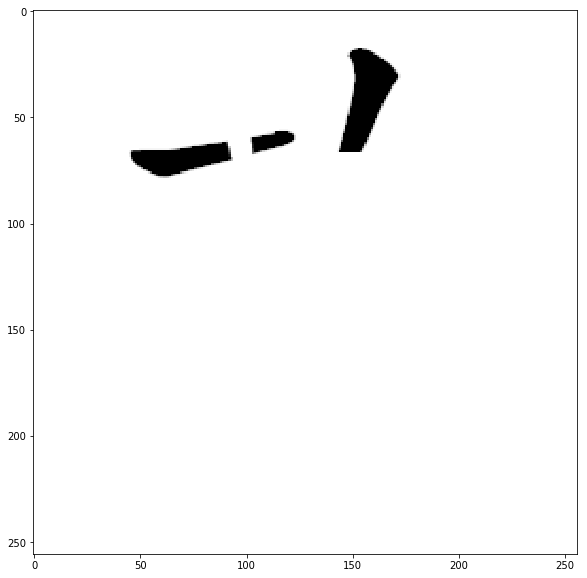

In [395]:
plt.figure(figsize=[20,10])
plt.imshow(diff, cmap="Greys")
plt.show()

In [396]:
diff_signal = []

for i in range(len(files)-1):
    diff, grey_scaled, grey_scaled2 = Calc_Photo_Diff(files[i],files[i+1])
    diff_signal += [np.max(np.abs(diff))]

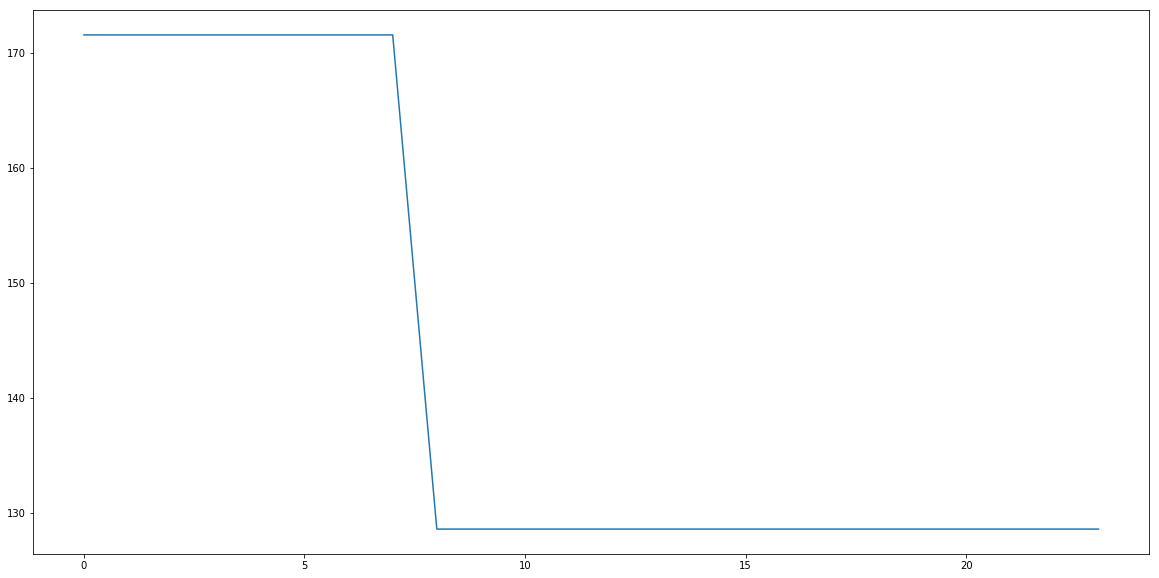

In [397]:
plt.figure(figsize=[20,10])

plt.plot(diff_signal)

plt.show()

In [370]:
stroke_timing = [float(x.split("/")[-1].split("-")[-1][:-5]) for x in files]

In [371]:
def Segment_Signal(X):
    i = 0
    rising_loc = []
    falling_loc = []
    thres = 0
    rising_edge = True
    
    while i < len(X):
        if rising_edge:
            if X[i] > 0:
                rising_loc += [i]
                rising_edge = False
        else:
            if X[i] == 0:
                falling_loc += [i]
                rising_edge = True
        i += 1
    return rising_loc,falling_loc

In [372]:
rising_loc,falling_loc = Segment_Signal(diff_signal)

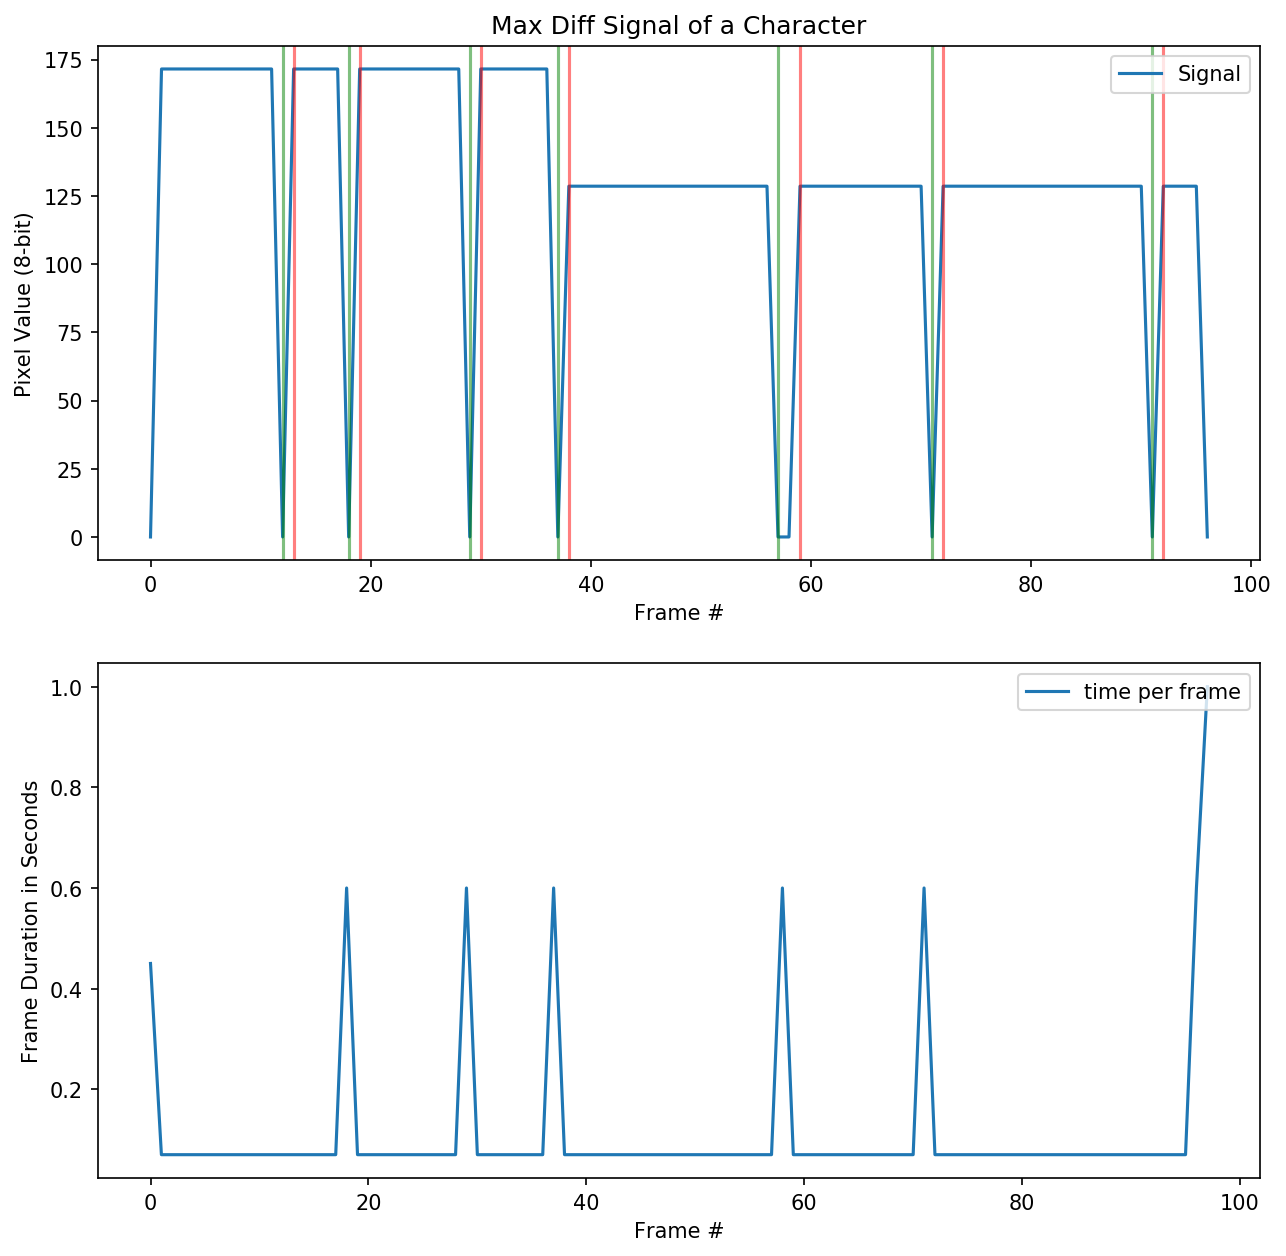

In [373]:
plt.figure(figsize=[10,10], dpi = 150)

plt.subplot(211)
plt.title("Max Diff Signal of a Character")

plt.plot(diff_signal, label = "Signal")

for ele in rising_loc[1:]:
    plt.axvline(ele, color = 'r', alpha = 0.5)
    
for ele in falling_loc[:-1]:
    plt.axvline(ele, color = 'g', alpha = 0.5)
    
plt.ylabel("Pixel Value (8-bit)")
plt.xlabel("Frame #")
plt.legend(loc=1)

plt.subplot(212)

plt.plot(stroke_timing, label = "time per frame")
plt.ylabel("Frame Duration in Seconds")
plt.xlabel("Frame #")
plt.legend(loc=1)

plt.show()

In [374]:
rising_loc[1:]

[13, 19, 30, 38, 59, 72, 92]

In [375]:
falling_loc[:-1]

[12, 18, 29, 37, 57, 71, 91]

In [376]:
i = 0
np.sum(stroke_timing[falling_loc[:-1][i]:rising_loc[1:][i]+1])

0.14

In [377]:
pauses = []
for i in range(len(rising_loc[1:])):
    pauses += [np.sum(stroke_timing[falling_loc[:-1][i]:rising_loc[1:][i]+1])]

In [378]:
pauses

[0.14,
 0.6699999999999999,
 0.6699999999999999,
 0.6699999999999999,
 0.74,
 0.6699999999999999,
 0.14]

In [379]:
falling_loc

[12, 18, 29, 37, 57, 71, 91, 96]

In [380]:
final_segmentation = []

for i in range(len(pauses)):
    if pauses[i] >= 0.2:
        final_segmentation.append(falling_loc[i])
final_segmentation.append(falling_loc[-1])

In [381]:
final_segmentation

[18, 29, 37, 57, 71, 96]

In [382]:
from shutil import copyfile

target_loc = "chars/%s/"%char

if not os.path.exists(target_loc):
    os.makedirs(target_loc)

i = 1
copyfile(files[0], target_loc+"0.png")
for ele in final_segmentation:
    
    copyfile(files[ele], target_loc+str(i)+".png")
    i+=1


# Convert Stroke Images to CSV

In [386]:
tartget_dir = target_loc
files = sorted(glob.glob(tartget_dir+"*.png"))
files

['chars/ta/0.png',
 'chars/ta/1.png',
 'chars/ta/2.png',
 'chars/ta/3.png',
 'chars/ta/4.png',
 'chars/ta/5.png',
 'chars/ta/6.png']

In [387]:
templates = []
for i in range(len(files)-1):
    x,y,z = Calc_Photo_Diff(files[i],files[i+1])
    templates.append((np.array(x) > 0)*1) #Import Grayscale subtraction and convert to BINARY map

In [388]:
for template in range(len(templates)):
    np.savetxt(tartget_dir+str(template)+'.csv', templates[template].astype(np.int), fmt='%d', delimiter=',')
